In [1]:
!pwd

/home/jetson


In [2]:
%cd ~/Documents/Glasses_Detection_with_YOLOv5/yolov5

/home/jetson/Documents/Glasses_Detection_with_YOLOv5/yolov5


In [3]:
import os
import torch
import torch.nn.utils.prune as prune
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import gc
from utils.datasets import create_dataloader
from utils.general import (LOGGER, box_iou, check_dataset, check_img_size, check_requirements, check_yaml,
                           coco80_to_coco91_class, colorstr, increment_path, non_max_suppression, print_args,
                           scale_coords, xywh2xyxy, xyxy2xywh)
from utils.metrics import ConfusionMatrix, ap_per_class
from utils.plots import output_to_target, plot_images, plot_val_study
from utils.torch_utils import select_device, time_sync
import torch_pruning as tp

In [4]:
device = "cuda:0"

In [5]:
def apply_prune(model, pruning_ratio=0.3, real_pruning=False, mode='Structured'):
    print('Pruning model with ratio = {}... '.format(pruning_ratio), end='')
    if mode == 'Structured':
        pruning_ratio = 1 - np.sqrt(1 - pruning_ratio) # for removing amount of parameters / structured pruning removes channel
    if not real_pruning:
        for name, m in model.named_modules():
            if isinstance(m, torch.nn.Conv2d):
                if mode == 'Structured':
                    prune.ln_structured(m, name='weight', amount=pruning_ratio, n=1, dim=1)  # prune
                elif mode == 'Unstructured':
                    prune.l1_unstructured(m, name='weight', amount=pruning_ratio)  # prune
                prune.remove(m, 'weight')  # make permanent
                
        for p in model.parameters():
            p.requires_grad_(True)
    else:
        #print(model.model)
        for p in model.parameters():
            p.requires_grad_(True)
        example_inputs = torch.randn(1, 3, 640, 640).to(device)
    
        ignored_layers = []
        from models.yolo import Detect
        for m in model.model.modules():
            if isinstance(m, Detect):
                ignored_layers.append(m)
        #print(ignored_layers)

        iterative_steps = 1 # progressive pruning
        pruner = tp.pruner.GroupNormPruner(
            model.model,
            example_inputs,
            importance=tp.importance.GroupNormImportance(p=1, normalizer=None, group_reduction='sum'),
            global_pruning=False,
            isomorphic=False,
            iterative_steps=iterative_steps,
            pruning_ratio=pruning_ratio, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
            ignored_layers=ignored_layers,
        )
        pruner.step()
    print('Pruning end. Calculating model information...')
    return model

def get_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    model_size = os.path.getsize("tmp.pt")/1e6
    print("model_size: %.2f MB" %(model_size))
    os.remove('tmp.pt')
    return model_size

def flops_and_params(model):
    example_inputs = torch.randn(1, 3, 640, 640).to(device)
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    flops = 2 * macs
    return flops, nparams

In [6]:
def process_batch(detections, labels, iouv):
    """
    Return correct predictions matrix. Both sets of boxes are in (x1, y1, x2, y2) format.
    Arguments:
        detections (Array[N, 6]), x1, y1, x2, y2, conf, class
        labels (Array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (Array[N, 10]), for 10 IoU levels
    """
    correct = torch.zeros(detections.shape[0], iouv.shape[0], dtype=torch.bool, device=iouv.device)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    x = torch.where((iou >= iouv[0]) & (labels[:, 0:1] == detections[:, 5]))  # IoU above threshold and classes match
    if x[0].shape[0]:
        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detection, iou]
        if x[0].shape[0] > 1:
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            # matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        matches = torch.Tensor(matches).to(iouv.device)
        correct[matches[:, 1].long()] = matches[:, 2:3] >= iouv
    return correct

def evaluate(model, data_yaml, device='cuda:0', img_size=640, batch_size=32, conf_thres=0.001, iou_thres=0.6, half=True):
    """
    YOLOv5 모델 테스트 함수 (2022년 초 버전 기반).
    
    Args:
        model (torch.nn.Module): PyTorch YOLOv5 모델 객체
        data_yaml (str or Path): 데이터셋 yaml 파일 경로
        device (str): 'cuda' 또는 'cpu'
        img_size (int): 입력 이미지 크기 (정사각형 기준)
        batch_size (int): 배치 크기
        conf_thres (float): Confidence threshold
        iou_thres (float): IoU threshold for NMS
    
    Returns:
        dict: 테스트 결과 메트릭 (Precision, Recall, mAP@0.5, mAP@0.5:0.95)
    """
    # 디바이스 설정
    device = torch.device(device)

    # 데이터셋 확인
    data = check_dataset(data_yaml)
    
    model.eval()
    is_coco = isinstance(data.get('val'), str) and data['val'].endswith('coco/val2017.txt')  # COCO dataset
    nc = int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()
    
    pad = 0.5
    task = 'val'  # path to train/val/test images
    dataloader = create_dataloader(data[task], img_size, batch_size, model.stride, False, pad=pad, rect=True,
                                    workers=8, prefix=colorstr(f'{task}: '))[0]
    
    seen = 0
    names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)}
    class_map = list(range(1000))
    s = ('%20s' + '%11s' * 6) % ('Class', 'Images', 'Labels', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
    dt, p, r, f1, mp, mr, map50, map = [0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    pbar = tqdm(dataloader, desc=s, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    
    for batch_i, (im, targets, paths, shapes) in enumerate(pbar):
        t1 = time_sync()
        im = im.to(device, non_blocking=True)
        targets = targets.to(device)
        im = im.half() if half else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        nb, _, height, width = im.shape  # batch size, channels, height, width
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        out = model(im, augment=False)  # inference, loss outputs
        dt[1] += time_sync() - t2

        # NMS
        targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)  # to pixels
        lb = []  # for autolabelling
        t3 = time_sync()
        out = non_max_suppression(out, conf_thres, iou_thres, labels=lb, multi_label=True, agnostic=False)
        dt[2] += time_sync() - t3

        # Metrics
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            path, shape = Path(paths[si]), shapes[si][0]
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            predn = pred.clone()
            scale_coords(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_coords(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
                
            else:
                correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))  # (correct, conf, pcls, tcls)

    # Compute metrics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)

    # Print results
    pf = '%20s' + '%11i' * 2 + '%11.3g' * 4  # print format
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))

    # Print speeds
    t = tuple(x / seen * 1E3 for x in dt)  # speeds per image
    shape = (batch_size, 3, img_size, img_size)
    print(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {shape}' % t)

    # 결과 반환
    results = {
        'Precision': mp,
        'Recall': mr,
        'mAP@0.5': map50,
        'mAP@0.5:0.95': map
    }
    return (results, t)

# Example Usage (adjust paths as needed):
# test_yolov5_v1(model, data_yaml='data/coco128.yaml', device='cuda')

In [ ]:
def evaluate_pruning(weight='n', real_pruning=False, mode='Unstructured', half=False):
    pruning_ratios = np.linspace(0.0, 0.9, 10)  # 0%, 10%, ..., 50%
    results = []
    inform = []

    model = torch.hub.load('.', 'custom', '../finetuned_weights/yolov5{}_finetuned.pt'.format(weight), source='local', force_reload=True, device=device)

    for i, ratio in enumerate(pruning_ratios):
        print('({}) pruning ratio: {}'.format(i+1, ratio))
        pruned_model = apply_prune(model, pruning_ratio=ratio, real_pruning=real_pruning, mode=mode)
        flops, nparams = flops_and_params(pruned_model)
        print('FLOPs: %.3f GFLOPs, number of parameters: %d' % (flops / 1e9, nparams))
        model_size = get_model_size(pruned_model)
        metrics, times = evaluate(model=pruned_model, data_yaml='./data/glasses.yaml', device=device, half=half)
        results.append([ratio, metrics['Precision'], metrics['Recall'], metrics['mAP@0.5'], metrics['mAP@0.5:0.95'], times])
        inform.append([model_size, flops, nparams])
        print('pruning ratio {} complete'.format(ratio))
    
    del model
    gc.collect()
    
    return results, inform

In [8]:
%matplotlib inline
#results, informs = evaluate_pruning(weight=weight, real_pruning=False, mode='Unstructured')

def plot_results(weight, results, informs, real_pruning, mode):
    folder = '../pruning_results_2'
    # 데이터 추출
    ratios = [r[0] for r in results]
    precision_score = [r[1] for r in results]
    recall_score = [r[2] for r in results]
    map50_scores = [r[3] for r in results]
    map50_95_scores = [r[4] for r in results]
    inference_times = [r[5][1] for r in results]

    model_sizes = [i[0] for i in informs]
    flops = [i[1] for i in informs]
    nparams = [i[2] for i in informs]

    # 그래프 그리기
    fig, ax = plt.subplots(1, 3, figsize=(24,6))
    ax[0].plot(ratios, map50_scores, marker='o', label='mAP@0.5')
    ax[0].plot(ratios, map50_95_scores, marker='o', label='mAP@0.5:0.95')
    ax[0].set_title("mAP")
    ax[0].set_xlabel("Pruning Ratio")
    ax[0].set_ylabel("Performance")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(ratios, precision_score, color='r', marker='o', label='precision')
    ax[1].plot(ratios, recall_score, color='g', marker='o', label='recall')
    ax[1].set_title("Precision and Recall")
    ax[1].set_xlabel("Pruning Ratio")
    ax[1].set_ylabel("Performance")
    ax[1].legend()
    ax[1].grid(True)

    ax[2].plot(ratios, inference_times, color='m', marker='o', label='precision')
    ax[2].set_title("Inference Time")
    ax[2].set_xlabel("Pruning Ratio")
    ax[2].set_ylabel("time (ms)")
    ax[2].legend()
    ax[2].grid(True)

    fig.suptitle('YOLOv5{} {} {} Pruning Ratio vs Performance'.format(weight, 'Real' if real_pruning else 'Fake', mode))
    fig.tight_layout()
    plt.show()
    os.makedirs(folder, exist_ok=True)
    fig.savefig("{}/YOLOv5{}_{}_{}_Performance.png".format(folder, weight, 'Real' if real_pruning else 'Fake', mode))

    fig, ax = plt.subplots(1, 3, figsize=(24,6))
    ax[0].plot(ratios, model_sizes, 'bo-', label='model_size')
    ax[0].set_title("Model Size (MB)")
    ax[0].set_xlabel("Pruning Ratio")
    ax[0].set_ylabel("MB")
    ax[0].set_ylim(0, 1.4 * model_sizes[0])
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(ratios, flops, 'ro-', label='GFLOPs')
    ax[1].set_title("FLOPs (G)")
    ax[1].set_xlabel("Pruning Ratio")
    ax[1].set_ylabel("GFLOPs")
    ax[1].legend()
    ax[1].grid(True)

    ax[2].plot(ratios, nparams, 'go-', label='number of parameters(M)')
    ax[2].set_title("Number of parameters (M)")
    ax[2].set_xlabel("Pruning Ratio")
    ax[2].set_ylabel("# parameters (M)")
    ax[2].legend()
    ax[2].grid(True)

    fig.suptitle('YOLOv5{} {} {} Pruning Ratio vs Information'.format(weight, 'Real' if real_pruning else 'Fake', mode))
    fig.tight_layout()
    plt.show()
    os.makedirs(folder, exist_ok=True)
    fig.savefig("{}/YOLOv5{}_{}_{}_Information.png".format(folder, weight, 'Real' if real_pruning else 'Fake', mode))

YOLOv5 🚀 0a5a1b4 torch 1.8.0 CUDA:0 (NVIDIA Tegra X1, 3964MiB)

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


(1) pruning ratio: 0.0
Pruning model with ratio = 0.0... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [01:43<00:00, 20.66s/it]


                 all        134        141       0.97      0.899      0.966      0.555
Speed: 97.5ms pre-process, 281.8ms inference, 31.0ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.0 complete
(2) pruning ratio: 0.1
Pruning model with ratio = 0.1... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


                 all        134        141      0.953      0.892      0.963      0.506
Speed: 1.8ms pre-process, 52.1ms inference, 14.1ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.1 complete
(3) pruning ratio: 0.2
Pruning model with ratio = 0.2... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


                 all        134        141      0.834       0.89      0.915      0.479
Speed: 2.1ms pre-process, 51.5ms inference, 13.0ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.2 complete
(4) pruning ratio: 0.30000000000000004
Pruning model with ratio = 0.30000000000000004... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.69s/it]


                 all        134        141       0.59      0.687      0.644      0.237
Speed: 1.7ms pre-process, 51.3ms inference, 14.4ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.30000000000000004 complete
(5) pruning ratio: 0.4
Pruning model with ratio = 0.4... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.70s/it]


                 all        134        141      0.573      0.383       0.38      0.106
Speed: 1.9ms pre-process, 51.2ms inference, 12.1ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.4 complete
(6) pruning ratio: 0.5
Pruning model with ratio = 0.5... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:44<00:00,  8.91s/it]


                 all        134        141       0.16     0.0432     0.0302    0.00594
Speed: 1.7ms pre-process, 51.3ms inference, 11.7ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.5 complete
(7) pruning ratio: 0.6000000000000001
Pruning model with ratio = 0.6000000000000001... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.77s/it]


                 all        134        141   0.000343     0.0185   0.000189   3.78e-05
Speed: 1.6ms pre-process, 51.4ms inference, 11.4ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.6000000000000001 complete
(8) pruning ratio: 0.7000000000000001
Pruning model with ratio = 0.7000000000000001... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


                 all        134          0          0          0          0          0
Speed: 1.7ms pre-process, 51.4ms inference, 7.9ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.7000000000000001 complete
(9) pruning ratio: 0.8
Pruning model with ratio = 0.8... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]


                 all        134          0          0          0          0          0
Speed: 2.1ms pre-process, 51.5ms inference, 8.0ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.8 complete
(10) pruning ratio: 0.9
Pruning model with ratio = 0.9... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.71s/it]


                 all        134          0          0          0          0          0
Speed: 2.4ms pre-process, 51.5ms inference, 7.0ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.9 complete


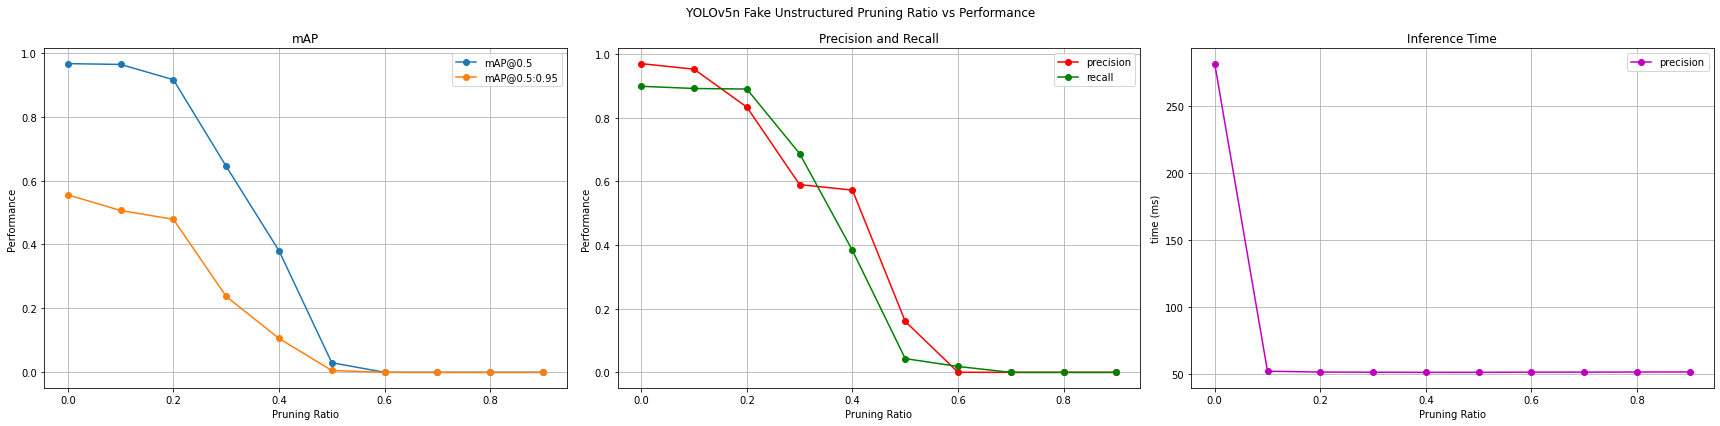

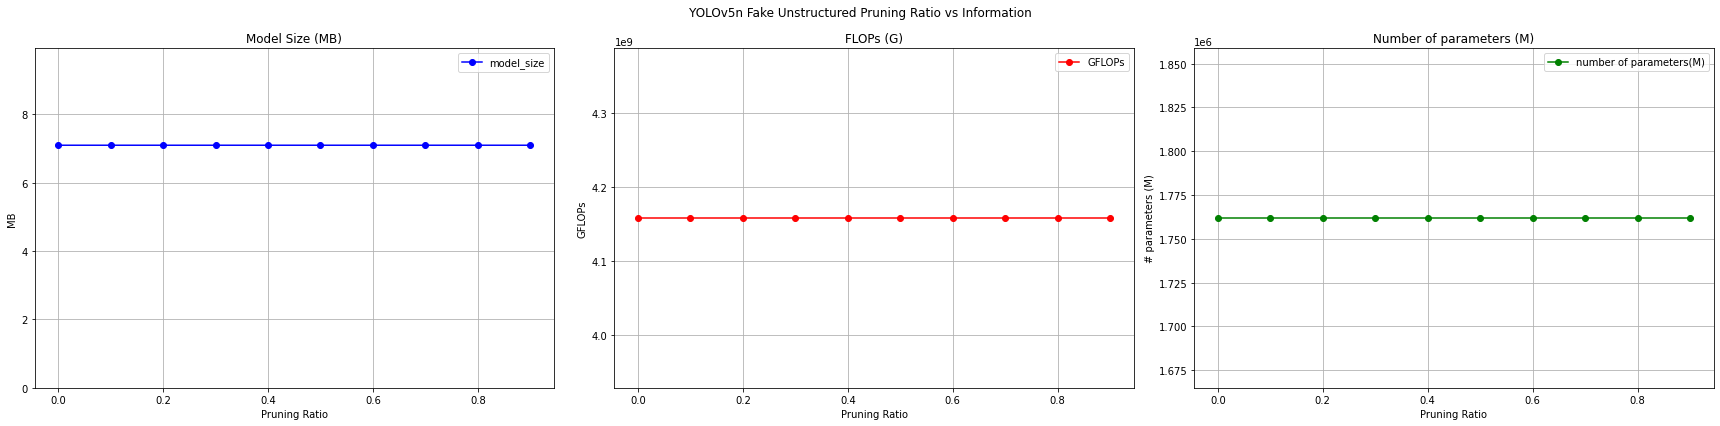

YOLOv5 🚀 0a5a1b4 torch 1.8.0 CUDA:0 (NVIDIA Tegra X1, 3964MiB)

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


(1) pruning ratio: 0.0
Pruning model with ratio = 0.0... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:46<00:00,  9.32s/it]


                 all        134        141       0.97      0.899      0.966      0.555
Speed: 1.7ms pre-process, 51.3ms inference, 16.0ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.0 complete
(2) pruning ratio: 0.1
Pruning model with ratio = 0.1... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:52<00:00, 10.58s/it]


                 all        134        141      0.478      0.331      0.304      0.097
Speed: 2.3ms pre-process, 101.5ms inference, 16.3ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.1 complete
(3) pruning ratio: 0.2
Pruning model with ratio = 0.2... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:44<00:00,  8.89s/it]


                 all        134        141      0.778      0.037     0.0436     0.0108
Speed: 1.8ms pre-process, 51.4ms inference, 13.3ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.2 complete
(4) pruning ratio: 0.30000000000000004
Pruning model with ratio = 0.30000000000000004... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.62s/it]


                 all        134        141    0.00384    0.00227    0.00128   0.000227
Speed: 1.7ms pre-process, 52.0ms inference, 13.5ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.30000000000000004 complete
(5) pruning ratio: 0.4
Pruning model with ratio = 0.4... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]


                 all        134        141   0.000204    0.00833   0.000142   5.69e-05
Speed: 2.2ms pre-process, 51.7ms inference, 8.8ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.4 complete
(6) pruning ratio: 0.5
Pruning model with ratio = 0.5... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.21s/it]


                 all        134          0          0          0          0          0
Speed: 1.8ms pre-process, 51.4ms inference, 8.6ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.5 complete
(7) pruning ratio: 0.6000000000000001
Pruning model with ratio = 0.6000000000000001... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.26s/it]


                 all        134        141   0.000426      0.185   0.000322   5.05e-05
Speed: 1.8ms pre-process, 51.4ms inference, 11.3ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.6000000000000001 complete
(8) pruning ratio: 0.7000000000000001
Pruning model with ratio = 0.7000000000000001... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]


                 all        134        141   0.000401      0.136   0.000309   7.15e-05
Speed: 1.8ms pre-process, 51.3ms inference, 10.7ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.7000000000000001 complete
(9) pruning ratio: 0.8
Pruning model with ratio = 0.8... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:42<00:00,  8.56s/it]


                 all        134        141   0.000249      0.123   0.000264   4.88e-05
Speed: 1.6ms pre-process, 51.4ms inference, 12.8ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.8 complete
(10) pruning ratio: 0.9
Pruning model with ratio = 0.9... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:43<00:00,  8.62s/it]


                 all        134        141   0.000259     0.0617   0.000213   3.65e-05
Speed: 1.7ms pre-process, 51.4ms inference, 13.9ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.9 complete


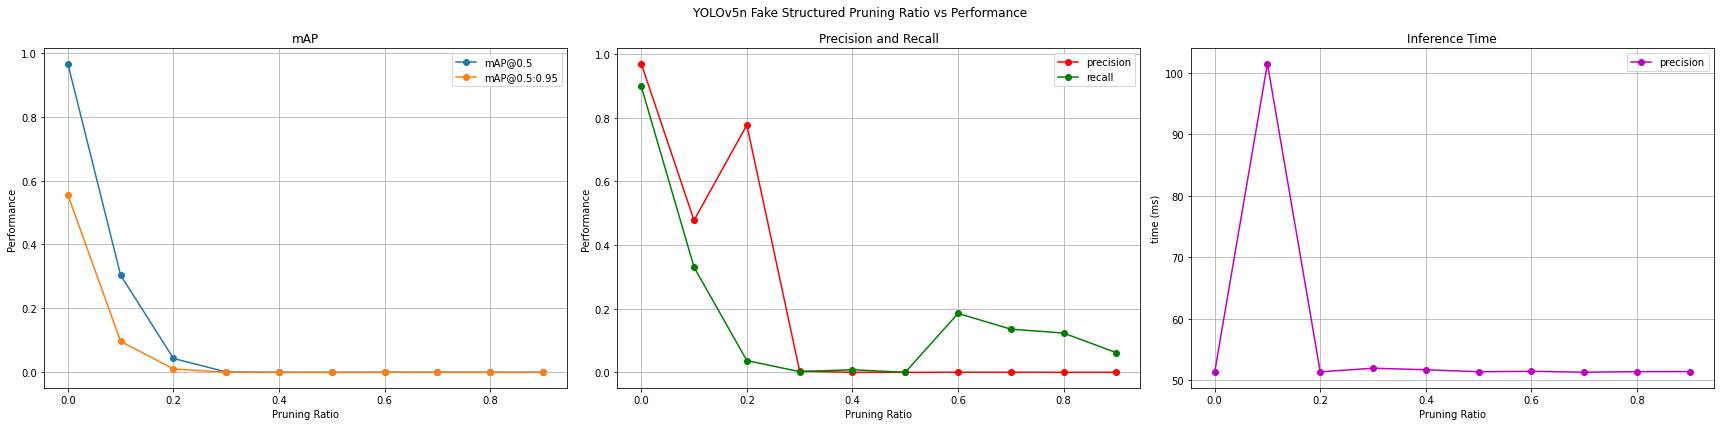

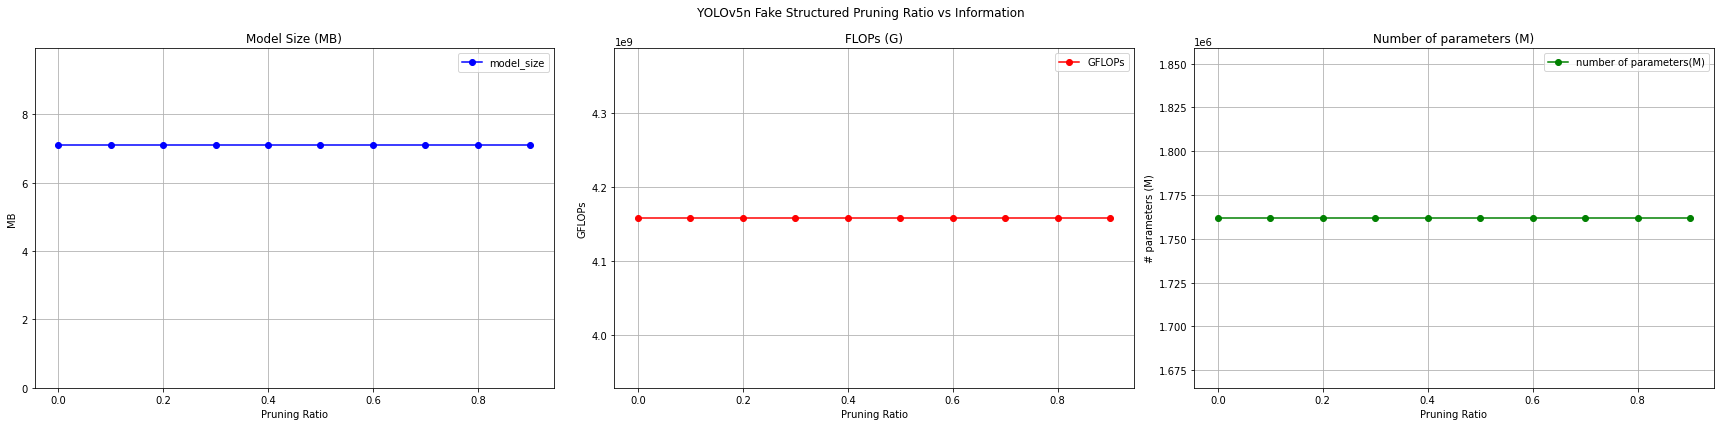

YOLOv5 🚀 0a5a1b4 torch 1.8.0 CUDA:0 (NVIDIA Tegra X1, 3964MiB)

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


(1) pruning ratio: 0.0
Pruning model with ratio = 0.0... Pruning end. Calculating model information...
FLOPs: 4.158 GFLOPs, number of parameters: 1761871
model_size: 7.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


                 all        134        141       0.97      0.899      0.966      0.555
Speed: 1.9ms pre-process, 51.2ms inference, 13.7ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.0 complete
(2) pruning ratio: 0.1
Pruning model with ratio = 0.1... Pruning end. Calculating model information...
FLOPs: 3.698 GFLOPs, number of parameters: 1568939
model_size: 6.33 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:45<00:00,  9.13s/it]


                 all        134          0          0          0          0          0
Speed: 3.2ms pre-process, 52.9ms inference, 8.3ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.1 complete
(3) pruning ratio: 0.2
Pruning model with ratio = 0.2... Pruning end. Calculating model information...
FLOPs: 2.909 GFLOPs, number of parameters: 1243599
model_size: 5.02 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:47<00:00,  9.46s/it]


                 all        134          0          0          0          0          0
Speed: 3.6ms pre-process, 49.3ms inference, 8.9ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.2 complete
(4) pruning ratio: 0.30000000000000004
Pruning model with ratio = 0.30000000000000004... Pruning end. Calculating model information...
FLOPs: 1.999 GFLOPs, number of parameters: 862137
model_size: 3.50 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:56<00:00, 11.26s/it]


                 all        134        141    0.00127     0.0247   0.000678   0.000134
Speed: 3.5ms pre-process, 42.4ms inference, 13.9ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.30000000000000004 complete
(5) pruning ratio: 0.4
Pruning model with ratio = 0.4... Pruning end. Calculating model information...
FLOPs: 1.199 GFLOPs, number of parameters: 511359
model_size: 2.10 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]


                 all        134          0          0          0          0          0
Speed: 2.6ms pre-process, 36.1ms inference, 2.2ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.4 complete
(6) pruning ratio: 0.5
Pruning model with ratio = 0.5... Pruning end. Calculating model information...
FLOPs: 0.594 GFLOPs, number of parameters: 251659
model_size: 1.06 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:41<00:00,  8.29s/it]


                 all        134          0          0          0          0          0
Speed: 2.2ms pre-process, 28.5ms inference, 1.2ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.5 complete
(7) pruning ratio: 0.6000000000000001
Pruning model with ratio = 0.6000000000000001... Pruning end. Calculating model information...
FLOPs: 0.234 GFLOPs, number of parameters: 98787
model_size: 0.45 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:44<00:00,  8.83s/it]


                 all        134        141   0.000361      0.179   0.000608   0.000104
Speed: 3.0ms pre-process, 20.0ms inference, 18.6ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.6000000000000001 complete
(8) pruning ratio: 0.7000000000000001
Pruning model with ratio = 0.7000000000000001... Pruning end. Calculating model information...
FLOPs: 0.078 GFLOPs, number of parameters: 29108
model_size: 0.17 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:55<00:00, 11.04s/it]


                 all        134        141   6.22e-05     0.0309    3.4e-05   5.37e-06
Speed: 3.4ms pre-process, 18.2ms inference, 69.1ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.7000000000000001 complete
(9) pruning ratio: 0.8
Pruning model with ratio = 0.8... Pruning end. Calculating model information...
FLOPs: 0.034 GFLOPs, number of parameters: 5730
model_size: 0.07 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:56<00:00, 11.27s/it]


                 all        134        141   0.000314      0.154   0.000348   7.54e-05
Speed: 3.5ms pre-process, 17.8ms inference, 63.3ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.8 complete
(10) pruning ratio: 0.9
Pruning model with ratio = 0.9... Pruning end. Calculating model information...
FLOPs: 0.029 GFLOPs, number of parameters: 1595
model_size: 0.06 MB


val: Scanning '../glasses_detection/data/labels.cache' images and labels... 134 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 5/5 [00:44<00:00,  8.96s/it]


                 all        134        141   0.000327       0.16   0.000223   5.03e-05
Speed: 2.9ms pre-process, 10.6ms inference, 31.2ms NMS per image at shape (32, 3, 640, 640)
pruning ratio 0.9 complete


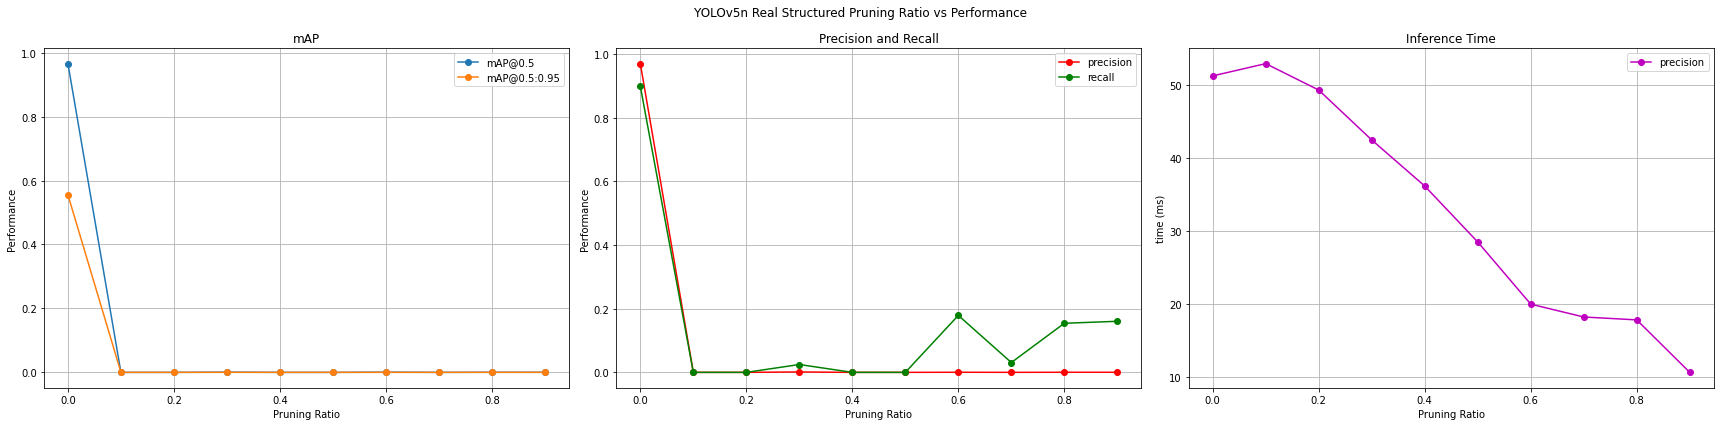

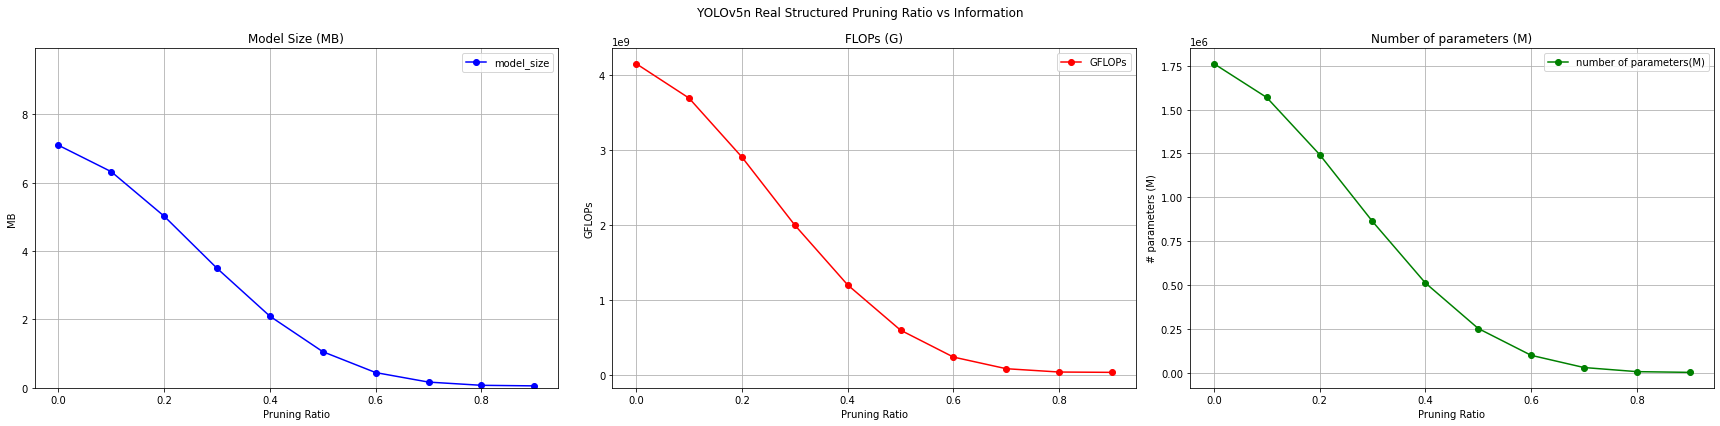

In [9]:
weight = 'n'
exp_list = [(False, 'Unstructured'), (False, 'Structured'), (True, 'Structured')]

for real_pruning, mode in exp_list:
    results, informs = evaluate_pruning(weight, real_pruning, mode)
    plot_results(weight, results, informs, real_pruning, mode)